<a href="https://www.kaggle.com/code/jorgeluiscruzquispe/ex-landlab-code?scriptVersionId=163581534" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# The Linear Diffusion Overland Flow Router

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

## Overview

This notebook demonstrates the `LinearDiffusionOverlandFlowRouter` Landlab component. The component implements a two-dimensional model of overland flow, based on a linearization of the diffusion-wave approximation of the shallow-water equations.

### Theory

#### Flow direction, depth, and velocity

The diffusion-wave equations are a simplified form of the 2D shallow-water equations in which energy slope is assumed to equal water-surface slope. Conservation of water mass is expressed in terms of the time derivative of the local water depth, $H$, and the spatial derivative (divergence) of the unit discharge vector $\mathbf{q} = UH$ (where $U$ is the 2D depth-averaged velocity vector):

$$\frac{\partial H}{\partial t} = R - \nabla\cdot \mathbf{q}$$

where $R$ is the local runoff rate [L/T] and $\mathbf{q}$ has dimensions of volume flow per time per width [L$^2$/T]. The flow velocity is calculated using a linearized form of the Manning friction law:

$$\mathbf{U} = \frac{H^{4/3}}{n^2 u_c} \nabla w$$

$$w = \eta + H$$

Here $\eta(x,y,t)$ is ground-surface elevation, $w(x,y,t)$ is water-surface elevation, $n$ is the Manning friction coefficient, and $u_c$ is a characteristic scale velocity (see, e.g., Mariotti, 2018). Thus, there are two parameters governing flow speed: $n$ and $u_c$. The may, however, be treated as a single lumped parameter $n^2 u_c$.

#### Rainfall and infiltration

Runoff rate is calculated as the difference between the rates of precipitation, $P$, and infiltration, $I$. The user specifies a precipitation rate (which is a public variable that can be modified after instantiation), and a maximum infiltration rate, $I_c$. The actual infiltration rate depends on the available surface water, and is calculated in a way that allows it to approach zero as the surface-water depth approaches zero:

$$I = I_c \left( 1 - e^{-H/H_i} \right)$$

where $H_i$ is a characteristic water depth, defined such that the actual infiltration rate is about 95% of $I_c$ when $H = 3 H_i$.

### Numerical Methods

#### Finite-volume representation

The component uses an explicit, forward-Euler finite-volume method. The solution for water depth at a new time step $k+1$ is calculated from:

$$H_i^{k+1} = H_i^k + \Delta t \left[ \frac{dH_i}{dt} \right]_i^k$$

The time derivative at step $k$ is calculated as:

$$\left[ \frac{dH_i}{dt} \right]_i^k = R - I - \frac{1}{\Lambda_i} \sum_{j=1}^{N_i} \lambda_{ij} q_{ij}$$

where $R$ is rainfall rate, $I$ is infiltration rate (calculated as above), $\Lambda_i$ is the horizontal surface area of the cell enclosing node $i$, $\lambda_{ij}$ is the length of the cell face between node $i$ and its $j$-th neighbor, and $q_{ij}$ is the specific water discharge along the link that connects node $i$ and its $j$-th neighbor.

For a raster grid, this treatment is equivalent to a centered-in-space finite-difference arrangement. For more on finite-difference solutions to diffusion problems, see for example Slingerland and Kump (2011) and Press et al. (1986).

#### Time-step limiter

Because of the linearization described above, the flow model is effectively a diffusion problem with a space- and time-varying diffusivity, because the effective diffusivity $D$ depends on water depth:

$$D = \frac{H^{7/3}}{n^2 u_c}$$

One numerical challenge is that, according to the Courant-Levy-Friedrichs (CFL) criterion, the maximum stable time step will depend on water depth, which varies in space and time. To prevent instability, the solution algorithm calculates at every iteration a maximum value for $D$ using the current maximum water depth (or a very small minimum value, whichever is larger, to prevent blowup in the case of zero water depth). The maximum step size is then calculated as:

$$\Delta t_\text{max} = \alpha \frac{L_\text{min}^2}{2 D}$$

where $L_\text{min}$ is the length of the shortest link in the grid (which is just equal to node spacing, $\Delta x$, for a uniform raster or hex grid). The stability factor $\alpha$ is a user-controllable parameter that defaults to 0.2, and must be $\le 1$.

If $\Delta t_\text{max}$ is less than the user-specified "global" time step duration, the algorithm iterates repeatedly with time steps of size $\Delta t_\text{max}$ (or the remaining time in the global step, whichever is smaller) until the global time step duration has been completed.


### The component

Import the needed libraries, then inspect the component's docstring:

In [1]:
!pip install -q shapely
!pip install -q landlab

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab 4.0.11 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.2 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.8.1 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from landlab import RasterModelGrid, imshow_grid
from landlab.components.overland_flow import LinearDiffusionOverlandFlowRouter
from landlab.io.esri_ascii import read_esri_ascii

Use the `help` function to get a description of the `LinearDiffusionOverlandFlowRouter` component. If you scroll down to the `__init__` section, you will see a list of parameters.

In [3]:
help(LinearDiffusionOverlandFlowRouter)

Help on class LinearDiffusionOverlandFlowRouter in module landlab.components.overland_flow.linear_diffusion_overland_flow_router:

class LinearDiffusionOverlandFlowRouter(landlab.core.model_component.Component)
 |  LinearDiffusionOverlandFlowRouter(grid, roughness=0.01, rain_rate=1e-05, infilt_rate=0.0, infilt_depth_scale=0.001, velocity_scale=1.0, cfl_factor=0.2)
 |  
 |  Calculate water flow over topography.
 |  
 |  Landlab component that implements a two-dimensional, linearized
 |  diffusion-wave model. The diffusion-wave approximation is a simplification
 |  of the shallow-water equations that omits the momentum terms. The flow
 |  velocity is calculated using the local water-surface slope as an
 |  approximation of the energy slope. With this linearized form, flow velocity
 |  is calculated using a linearized Manning equation, with the water-surface
 |  slope being used as the slope factor. There are two governing equations, one
 |  that represents conservation of water mass:
 | 

## Example 1: downpour on a single cell

The first example tests that the component can reproduce the expected steady flow depth for rain on a single cell. The input water flow rate, in $m^3 / s$, is:

$$Q_\text{in} = P \Delta x^2$$

The output flow rate is

$$Q_\text{out} = \frac{\Delta x}{n^2 u_c} H^{7/3} S_w$$

where $S_w$ is the water surface slope. We can write the water-surface slope in terms of the water height of the (one) core node (which just equals $H$, because the ground elevation is zero) and the water height at the adjacent open-boundary node, which is zero, so

$$S_w = \frac{H}{\Delta x}$$

We can therefore plug this into the equation for $Q_\text{out}$ and solve for the expected equilibrium depth:

$$H = \left(\Delta x^2 P n^2 u_c \right)^{3/10}$$

Pick the initial and run conditions

In [4]:
# Process parameters
n = 0.01  # roughness coefficient, (s/m^(1/3))
vel_scale = 1.0  # velocity scale, m/s
R = 72.0 / (3600.0 * 1000.0)  # runoff rate, m/s

# Run-control parameters
run_time = 360.0  # duration of run, (s)
nrows = 3  # number of node rows
ncols = 3  # number of node columns
dx = 2.0  # node spacing, m
dt = 20.0  # time-step size, s
plot_every = 60.0  # plot interval, s

# Derived parameters
num_steps = int(run_time / dt)

Create grid and fields:


In [5]:
# create and set up grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(False, True, True, True)  # open only on east

# add required field
elev = grid.add_zeros("topographic__elevation", at="node")

/opt/conda/lib/python3.10/site-packages/landlab/graph/graph.py:412: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["node"]
/opt/conda/lib/python3.10/site-packages/landlab/graph/graph.py:535: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["link"]
/opt/conda/lib/python3.10/site-packages/landlab/graph/graph.py:984: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`

In [6]:
# Instantiate the component
olflow = LinearDiffusionOverlandFlowRouter(
    grid, rain_rate=R, roughness=n, velocity_scale=vel_scale
)

In [7]:
# Helpful function to plot the profile


def plot_flow_profile(grid, olflow):
    """Plot the middle row of topography and water surface
    for the overland flow model olflow."""
    nc = grid.number_of_node_columns
    nr = grid.number_of_node_rows
    startnode = nc * (nr // 2) + 1
    midrow = np.arange(startnode, startnode + nc - 1, dtype=int)
    topo = grid.at_node["topographic__elevation"]
    plt.plot(
        grid.x_of_node[midrow],
        topo[midrow] + grid.at_node["surface_water__depth"][midrow],
        "b",
    )
    plt.plot(grid.x_of_node[midrow], topo[midrow], "k")
    plt.xlabel("Distance (m)")
    plt.ylabel("Ground and water surface height (m)")

Run the component forward in time, plotting the output in the form of a profile:

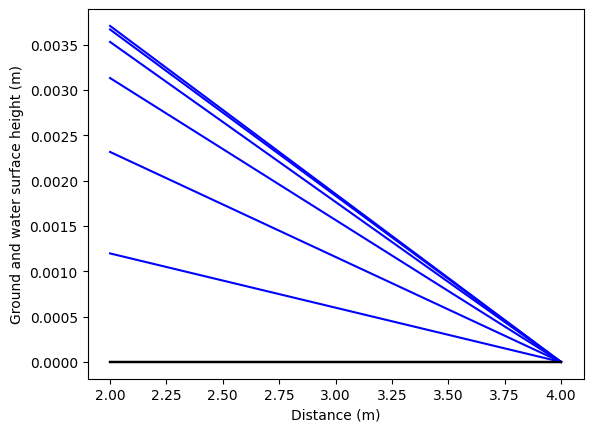

In [8]:
next_plot = plot_every
HH = []  # keep track of depth through time
for i in range(num_steps):
    olflow.run_one_step(dt)
    if (i + 1) * dt >= next_plot:
        plot_flow_profile(grid, olflow)
        next_plot += plot_every
    HH.append(grid.at_node["surface_water__depth"][4])

In [9]:
# Compare with analytical solution for depth
expected_depth = (dx * dx * R * n * n * vel_scale) ** 0.3
computed_depth = grid.at_node["surface_water__depth"][4]

print(f"Expected depth = {expected_depth} m")
print(
    f"Computed depth = {computed_depth} m",
)

Expected depth = 0.0037232911332721395 m
Computed depth = 0.0037082204564142748 m


Text(0, 0.5, 'Water depth (m)')

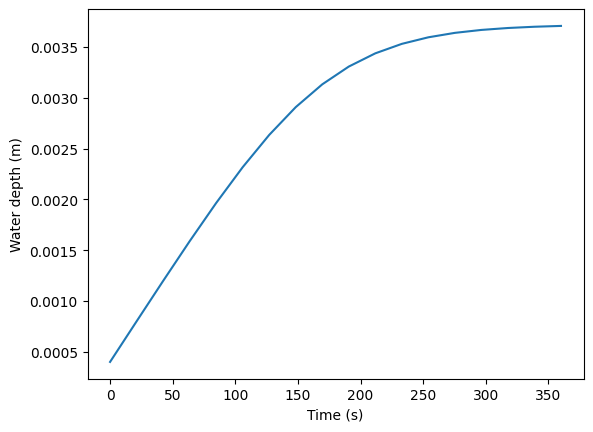

In [10]:
plt.plot(np.linspace(0, run_time, len(HH)), HH)
plt.xlabel("Time (s)")
plt.ylabel("Water depth (m)")

## Example 2: overland flow on a DEM

For this example, we'll import a small digital elevation model (DEM) for a site in New Mexico, USA, with 10 m cells.

In [11]:
# Process parameters
n = 0.1  # roughness coefficient, (s/m^(1/3))
uc = 1.0  # characteristic velocity scale (m/s)
R1 = 72.0 / (3600.0 * 1000.0)  # initial rainfall rate, m/s (converted from mm/hr)
R2 = 0.0 / (3600.0 * 1000.0)  # later rainfall rate, m/s (converted from mm/hr)
infilt_cap = 10.0 / (3600 * 1000.0)  # infiltration capacity, m/s (converted from mm/hr)

# Run-control parameters
heavy_rain_duration = 300.0  # duration of heavy rainfall, s
run_time = 1200.0  # duration of run, s
dt = 20.0  # time-step size, s
dem_filename = "/kaggle/input/landlab-repo-test/notebooks/tutorials/overland_flow/hugo_site.asc"

# Derived parameters
num_steps = int(run_time / dt)

# set up arrays to hold discharge, time, and rain rate
time_since_storm_start = np.linspace(0.0, run_time, num_steps + 1)
discharge = np.zeros(num_steps + 1)
rain_rate = np.zeros(num_steps + 1)
rain_rate[:] = R1
rain_rate[time_since_storm_start >= heavy_rain_duration] = R2

In [12]:
# Read the DEM file as a grid with a 'topographic__elevation' field
(grid, elev) = read_esri_ascii(dem_filename, name="topographic__elevation")

# Configure the boundaries: valid right-edge nodes will be open;
# all NODATA (= -9999) nodes will be closed.
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_FIXED_VALUE
grid.status_at_node[np.isclose(elev, -9999.0)] = grid.BC_NODE_IS_CLOSED

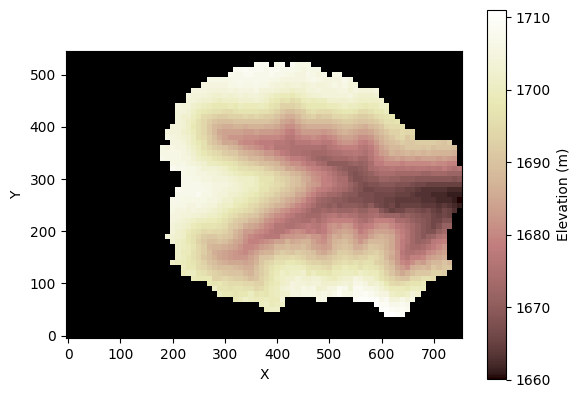

In [13]:
# display the topography
imshow_grid(grid, elev, colorbar_label="Elevation (m)", cmap="pink")

In [22]:
elev

array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

It would be nice to track discharge at the watershed outlet, but how do we find the outlet location? We actually have several valid nodes along the right-hand edge. Then we'll keep track of the field `water__specific_discharge` at the active links that connect to these boundary nodes. We can identify the nodes by the fact that they are (a) at the right-hand edge of the grid, and (b) have positive elevations (the ones with -9999 are outside of the watershed). We can identify the relevant active links as those connected to the outlet nodes that have active status (meaning they do not connect to any closed boundary nodes).

In [14]:
indices = np.where(elev[grid.nodes_at_right_edge] > 0.0)[0]
outlet_nodes = grid.nodes_at_right_edge[indices]
print(f"Outlet nodes: {outlet_nodes}")
print(f"Elevations of the outlet nodes: {elev[outlet_nodes]}")

links_at_outlets = grid.links_at_node[outlet_nodes]
links_to_track = links_at_outlets[
    grid.status_at_link[links_at_outlets] == grid.BC_LINK_IS_ACTIVE
].flatten()
print(f"Links at which to track discharge: {links_to_track}")

Outlet nodes: [1975 2051 2127 2203 2279 2355 2431 2507]
Elevations of the outlet nodes: [ 1661.  1660.  1661.  1662.  1665.  1669.  1672.  1676.]
Links at which to track discharge: [3849 4000 4151 4302 4453 4604 4755 4906]


In [15]:
# Instantiate the component
olflow = LinearDiffusionOverlandFlowRouter(
    grid, rain_rate=R, infilt_rate=infilt_cap, roughness=n, velocity_scale=vel_scale
)

In [16]:
def cfl():
    hmax = np.amax(grid.at_node["surface_water__depth"])
    D = hmax ** (7.0 / 3.0) / (n * n * uc)
    return 0.5 * dx * dx / D

In [17]:
q = grid.at_link["water__specific_discharge"]

for i in range(num_steps):
    olflow.rain_rate = rain_rate[i]
    olflow.run_one_step(dt)
    discharge[i + 1] = np.sum(q[links_to_track]) * dx

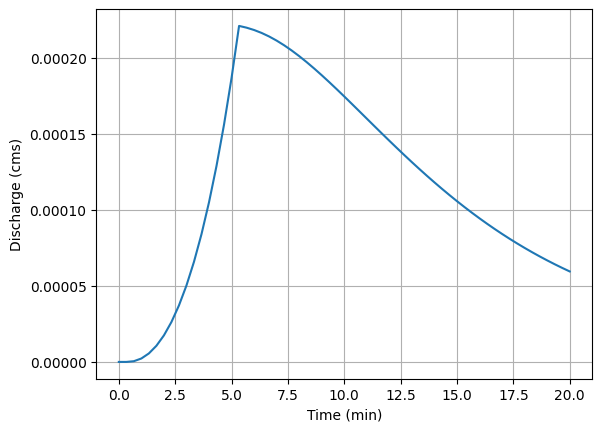

In [18]:
plt.plot(time_since_storm_start / 60.0, discharge)
plt.xlabel("Time (min)")
plt.ylabel("Discharge (cms)")
plt.grid(True)

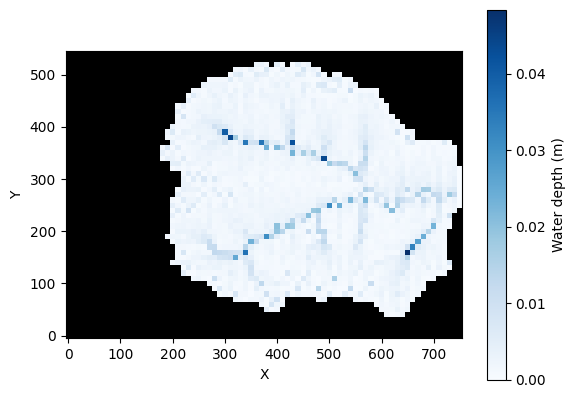

In [19]:
imshow_grid(
    grid,
    grid.at_node["surface_water__depth"],
    cmap="Blues",
    colorbar_label="Water depth (m)",
)

Voila! A fine hydrograph, and a water-depth map that shows deeper water in the channels (and highlights depressions and low-gradient spots in the topography).

## References

Mariotti, G. (2018). Marsh channel morphological response to sea level rise and sediment supply. Estuarine, Coastal and Shelf Science, 209, 89-101.

Press, W. H., Vetterling, W. T., Teukolsky, S. A., & Flannery, B. P. (1986). Numerical recipes. Cambridge: Cambridge university press.

Slingerland, R., & Kump, L. (2011). Mathematical Modeling of Earth's Dynamical Systems. Princeton University Press.